# Monetary policy in HANK

**Table of contents**<a id='toc0_'></a>    
- 1. [Setup](#toc1_)    
- 2. [Monetary policy](#toc2_)    
- 3. [Myopic Agents](#toc3_)    
- 4. [Sticky expectations](#toc4_)    
- 5. [Relax borrowing constraint](#toc5_)    

<!-- vscode-jupyter-toc-config
	numbering=true
	anchor=true
	flat=false
	minLevel=2
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt   
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
plt.rcParams.update({"axes.grid" : True, "grid.color": "black", "grid.alpha":"0.25", "grid.linestyle": "--"})
plt.rcParams.update({'font.size': 14})
from HANKModel import HANKModelClass
import numba as nb 

## 1. <a id='toc1_'></a>[Setup](#toc0_)

In [2]:
model = HANKModelClass(name='baseline')
model.find_ss(do_print=True)
model._compute_jac_hh()
model.calc_MPC()

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


 Y =   1.0000
 r    =   0.0050
 A    =   1.2072
 pD    =   1.2072
Discrepancy in A =  -0.00000000
Discrepancy in Y =   0.00000000
MPC = 0.33, iMPC[0,0] = 0.33
annual_MPC = 0.50


## 2. <a id='toc2_'></a>[Monetary policy](#toc0_)

Create RA model for comparison. 

As we will later need to modify jacobian of HH block we create the RA model by simply overwriting the HH jacobians in *jac_hh* with RA jacobians.  

In [3]:
# Copy RA model
model_RA = model.copy()

# Get Jacobian of RA model 
M_RA = model_RA.get_RA_J()

# overwrite HH jacobian such that GEModelTools uses RA jac 
for o in ['C_hh', 'A_hh']:
    for i in ['Z', 'ra']:
        model_RA.jac_hh[(o,i)] = M_RA[o][i]

Compute IRFs

In [4]:
model_RA.compute_jacs(skip_hh=True)
model_RA.find_IRFs(['eps_i']) # linear version of find transition path

model.compute_jacs(skip_hh=True)
model.find_IRFs(['eps_i'])

Decomposition

Note that the GEModelTools function *model.decompose_hh_path()* decomposes the effects on household aggregates (C,A) *non-linearly* (i.e. does not use the Jacobians) and so should **not** be used here.

In [5]:
model_RA.jac_hh[('C_hh', 'Z')] @ model_RA.IRF['Z']

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0.

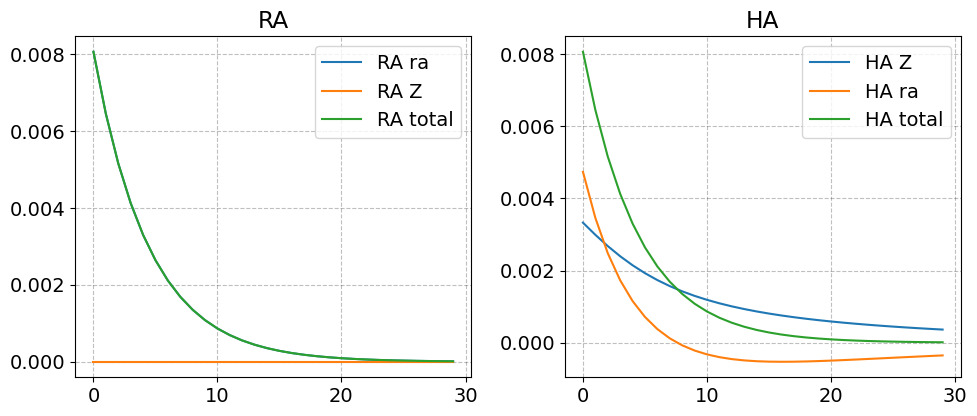

In [24]:
HA_ra = model.jac_hh[('C_hh', 'ra')] @ model.IRF['ra']
HA_Z = model.jac_hh[('C_hh', 'Z')] @ model.IRF['Z']

HA = HA_ra + HA_Z

RA_ra = model_RA.jac_hh[('C_hh', 'ra')] @ model_RA.IRF['ra']
RA_Z = model_RA.jac_hh[('C_hh', 'Z')] @ model_RA.IRF['Z']
RA = RA_ra + RA_Z


fig = plt.figure(figsize=(10,8))
ax = plt.subplot(2,2,1)
ax.set_title('RA')
ax.plot(RA_ra[:30], label='RA ra')
ax.plot(RA_Z[:30], label='RA Z')
ax.plot(RA[:30], label='RA total')
ax.legend()
ax = plt.subplot(2,2,2)
ax.set_title('HA')
ax.plot(HA_Z[:30], label='HA Z')
ax.plot(HA_ra[:30], label='HA ra')
ax.plot(HA[:30], label='HA total')
ax.legend()
plt.tight_layout()

## 3. <a id='toc3_'></a>[Myopic Agents](#toc0_)

Use the below function *create_alt_M* to construct the jacobians under alternative expectations.

If the RE HH jacobians are located in *model.jac_hh* you can create the alternative M matrix as:

<code> 
M = model.jac_hh[('C_hh','Z')] <br />
M_myopic =  create_alt_M(M.copy(), E_myopic) <br />
model_myopic.jac_hh[('C_hh')] = M_myopic
</code>

where *E_myopic* is the expectation matrix corresponding to myopic expectations. Note that you will need to do this for each output and input in the household block.

In [7]:
@nb.njit
def create_alt_M(M, E):
    """ Here, E is the expectation matrix, M is the RE Jacobian """
    T, m = M.shape
    assert T == m
    assert E.shape == (T, T)
    
    M_beh = np.empty_like(M)
    for t in range(T):
        for s in range(T):
            summand = 0
            for tau in range(min(s,t)+1):
                if tau > 0:
                    summand += (E[tau, s] - E[tau-1, s]) * M[t - tau, s - tau]
                else:
                    summand += E[tau, s] * M[t - tau, s - tau]
            M_beh[t, s] = summand
    return M_beh

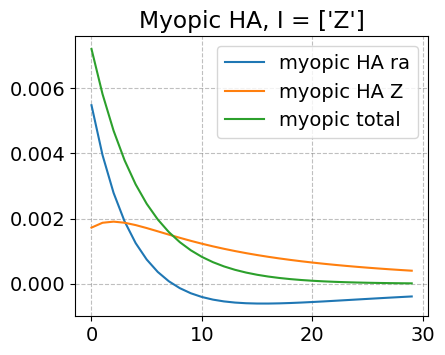

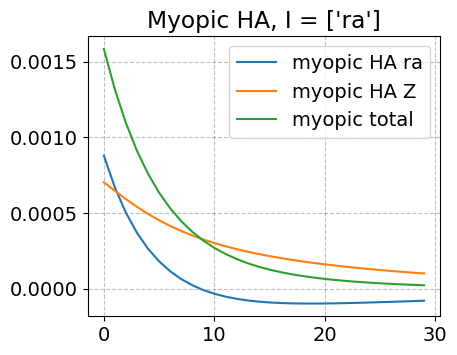

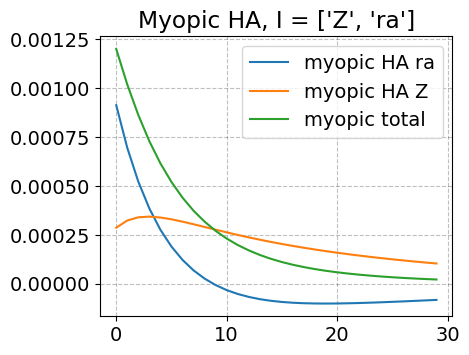

In [35]:
for I in [['Z'], ['ra'], ['Z', 'ra']]:

    model_myopic = model.copy()
    model_myopic.compute_jacs()
    T = model.par.T
    E_myopic = np.tril(np.ones((T,T))) # lower triangular part of 1s matrix

    for o in ['C_hh', 'A_hh']:
        for i in I:
            M = model.jac_hh[(o, i)]
            M_myopic = create_alt_M(M.copy(), E_myopic)    
            model_myopic.jac_hh[(o,i)] = M_myopic

    model_myopic.compute_jacs(skip_hh = True)
    model_myopic.find_IRFs(['eps_i'])
    myopic_ra = model_myopic.jac_hh[('C_hh', 'ra')] @ model_myopic.IRF['ra']
    myopic_Z = model_myopic.jac_hh[('C_hh', 'Z')] @ model_myopic.IRF['Z']

    myopic = myopic_ra + myopic_Z


    fig = plt.figure(figsize=(10,8))
    ax = plt.subplot(2,2,1)
    ax.set_title(f'Myopic HA, I = {I}')
    ax.plot(myopic_ra[:30], label='myopic HA ra')
    ax.plot(myopic_Z[:30], label='myopic HA Z')
    ax.plot(myopic[:30], label='myopic total')
    ax.legend()

    plt.show()


## 4. <a id='toc4_'></a>[Sticky expectations](#toc0_)

We assume households have sticky expectations w.r.t aggregates. Only a random fraction $1-\theta$ of households update their information set about the aggregate economy, hence learning about the MIT shock. 

The expectation matrix $\bf{E}$ is then given by:
\begin{gather*}
E=\left(\begin{array}{cccc}
1 & 1-\theta & 1-\theta & \cdots\\
1 & 1 & \left(1-\theta\right)^{2} & \cdots\\
1 & 1 & 1 & \cdots\\
\vdots & \vdots & \vdots & \ddots
\end{array}\right)
\end{gather*}
where we have ones on and below the diagonal since agents have perfect information w.r.t the current period aggregates. This ensures that they never violate their budget constraints. You can set $\theta=0.935$ following the estimates in Auclert et al. (2020).

In [ ]:
def E_sticky_exp(theta, T=300):
    col = 1 - theta**(1 + np.arange(T))
    E = np.tile(col[:, np.newaxis], (1, T))
    E = np.triu(E, +1) + np.tril(np.ones((T, T)))
    return E 

# Create expectations matrix 
E_sticky = E_sticky_exp(theta=0.935, T=model.par.T)

## 5. <a id='toc5_'></a>[Relax borrowing constraint](#toc0_)

First create a model with government debt

In [ ]:
model_B = HANKModelClass(name='baseline')
model_B.par.do_B = True
model_B.find_ss(do_print=True)
model_B._compute_jac_hh()
model_B.calc_MPC()

Then create alternate model with more relaxed borrowing constraint 

In [ ]:
model_B_HH_debt = HANKModelClass(name='baseline')
...